# ML in big scale - LAB 3

<center><img src='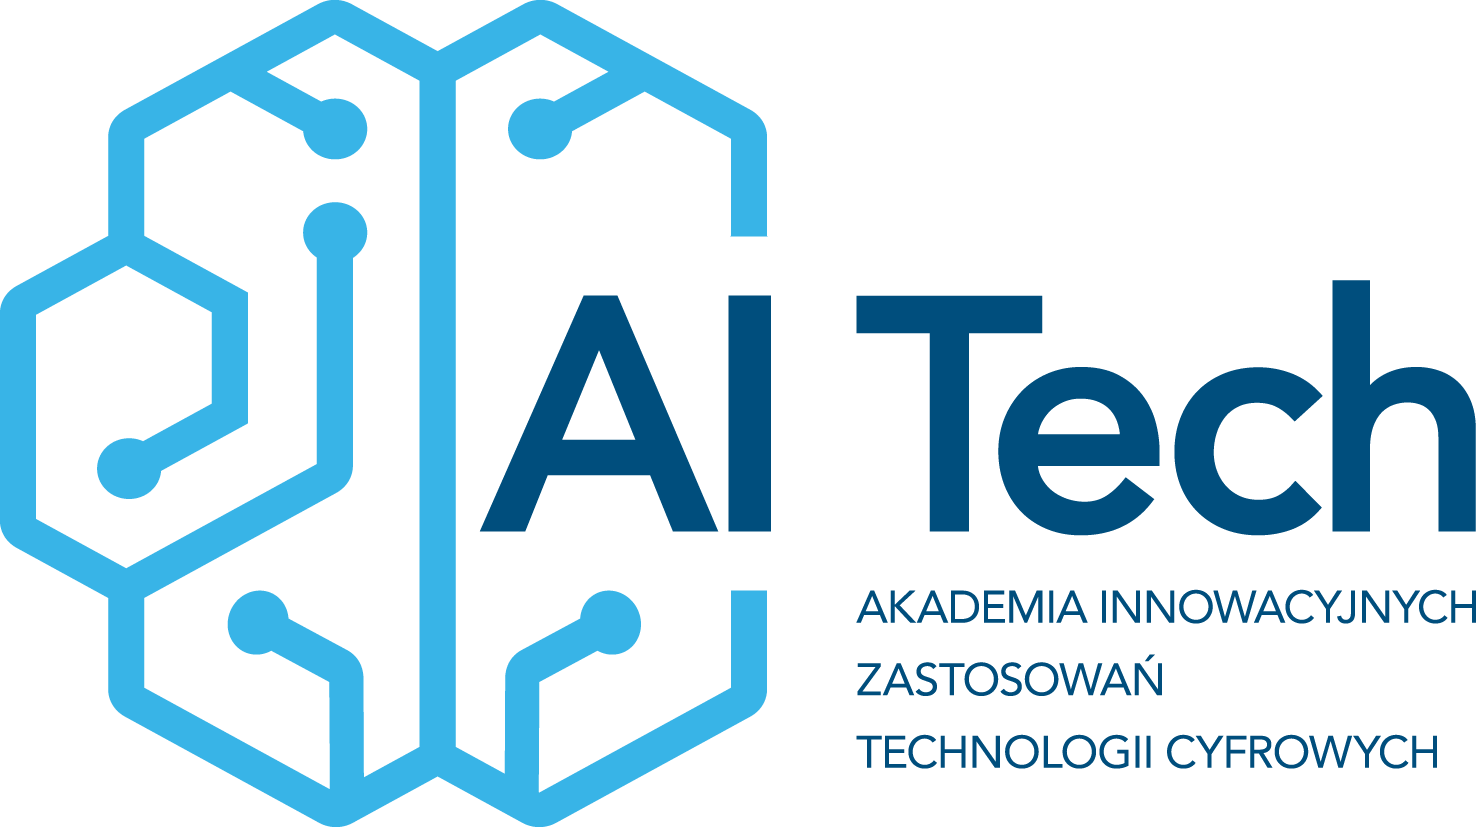
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>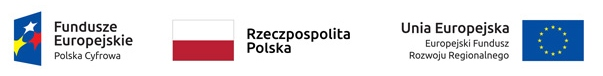</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Jacek Sroka**



Plan

1. Installation
2. Creating Spark Session
3. Reading data
4. Introduction to DataFrames
5. Specifying schema by hand
6. Querying with Python API
7. Querying with SQL




To **edit the colab** first copy it to your drive with the top bars `File -> Save a copy on drive` option.

## Installation
 

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.9 MB/s eta 0:00:00


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [4]:
# from pyspark import SparkContext, SparkConf
# 
# conf = SparkConf() \
#   .set('spark.ui.port', '4050').setAppName("mlibs").setMaster("local[*]")
# sc = SparkContext.getOrCreate(conf=conf)

## Creating Spark Session

This time, rather than `SparkContext`, we will be using `SparkSession`. It is a wrapper around `SparkContext`, but also adds extra functionality and higher level API.

In [5]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "1g") \
                    .appName("mlibs") \
                    .getOrCreate()

We can also get `SparkContext` from `SparkSession` and use it to access RDD API.

In [6]:
from pyspark import SparkContext
sc = spark.sparkContext

There is always one context for an application. If you try to create a new, before the previous one was closed, you will get the previous one.

In [7]:
print("First SparkContext:")
print(f"APP Name : {spark.sparkContext.appName}")
print(f"Master : {spark.sparkContext.master}")

spark2 = SparkSession.builder \
                     .master("local[2]") \
                     .appName("mlibs-spark2") \
                     .getOrCreate();

print("Second SparkContext:")
print(f"APP Name : {spark.sparkContext.appName}")
print(f"Master : {spark.sparkContext.master}")


First SparkContext:
APP Name : mlibs
Master : local[*]
Second SparkContext:
APP Name : mlibs
Master : local[*]


Note: pyspark documentation can be found [here](https://spark.apache.org/docs/3.1.2/api/python/reference/index.html). For example: list of `SparkContext` methods is [here](https://spark.apache.org/docs/3.1.2/api/python/reference/pyspark.html#spark-context-apis) and list of `SparkSession` methods is [here](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.SparkSession.html#pyspark.sql.SparkSession).


The following code allows us to inspect all the configuration. More about available configuration options and their default values can be found in [the documentation](https://spark.apache.org/docs/latest/configuration.html).

In [8]:
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.executor.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '39573'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.memory', '1g'),
 ('spark.app.id', 'local-167344963576

## Reading data
`SparkSession` has convenient methods for reading/writing data from/to common formats. The `load` method creates a DataFrame. It is similar to RDD, in the respect that rows can be distributed and processed independently on many machines.

In [9]:
housing = spark.read.load("sample_data/california_housing_test.csv",format="csv", sep=",", inferSchema="true", header="true")
housing.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|          330000.0|
|  -119.67|   36.33|              19.0|     1241.0|         244.0|     850.0|     237.0|       2.9375|           81700.0|
|  -119.56|   36.51|    

It is possible to convert RDDs to DataFrames.

In [10]:
institutes = [("Mathematics",10),("Informatics",20),("Mechanics",30)]
rdd = spark.sparkContext.parallelize(institutes)
df = rdd.toDF()
df.printSchema()
df.show(truncate=False)

root
 |-- _1: string (nullable = true)
 |-- _2: long (nullable = true)

+-----------+---+
|_1         |_2 |
+-----------+---+
|Mathematics|10 |
|Informatics|20 |
|Mechanics  |30 |
+-----------+---+



If we are not happy with the column names and types we can tweak them. The available types are the following:

```
StringType: string
BooleanType: boolean
IntegerType: int
LongType: bigint
FloatType: float
DoubleType: double
DateType: date
TimestampType: timestamp
BinaryType: binary
ByteType: tinyint
DecimalType: decimal(10,0)
ShortType: smallint
```
We can also use complex types like:
```
array<string>
map<int,string>
```

More about available types, their precision, supported value ranges, etc., can be found in the [documentation](https://spark.apache.org/docs/latest/sql-ref-datatypes.html).

In [11]:
rdd = spark.sparkContext.parallelize(institutes)
df = rdd.toDF(["name", "id"])
df = df.withColumn("id", df["id"].cast("string"))
df.printSchema()
df.show(truncate=False)

root
 |-- name: string (nullable = true)
 |-- id: string (nullable = true)

+-----------+---+
|name       |id |
+-----------+---+
|Mathematics|10 |
|Informatics|20 |
|Mechanics  |30 |
+-----------+---+



Note that when we loaded the `california_housing_test.csv` datafile, Spark inferred some schema by itself. This requires the data to be read and analysed. Later we will show how to define a schema by hand.

##  Introduction to DataFrames
Spark does not understand the content of RDDs. Each row is a black box object (or a key-value pair). DataFrames are organized into columns with values of the same type. Spark DataFrames are conceptually similar to Pandas DataFrames and tables in relational databases.

In [12]:
housing

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double]

Unlike RDDs, where the rows contain black box objects, Spark knows the data types and column names in DataFrames. This allows to write code that is easier to understand by humans, i.e., with column names rather than indexes of tuples.

In [13]:
housing.filter((housing["housing_median_age"]>=40) & (housing["housing_median_age"]<50)).sort("population").show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -118.44|   34.04|              49.0|       32.0|           7.0|      14.0|       7.0|       2.1875|          225000.0|
|   -121.9|   37.39|              42.0|       42.0|          14.0|      26.0|      14.0|       1.7361|          500001.0|
|  -121.84|   38.02|              46.0|       66.0|          22.0|      37.0|      21.0|        0.536|           87500.0|
|  -117.12|    34.1|              40.0|       96.0|          14.0|      46.0|      14.0|       3.2708|          162500.0|
|  -122.14|   38.03|              42.0|      118.0|          34.0|      54.0|      30.0|       2.5795|          225000.0|
|  -117.99|   33.81|    

It also makes additional optimisations possible. See [post](https://www.databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html) and [SIGMOD'15 paper](https://people.csail.mit.edu/matei/papers/2015/sigmod_spark_sql.pdf). We can check the physical plan of how a given graph would be executed by using the `explain` method.

In [14]:
housing.filter((housing["housing_median_age"]>=40) & (housing["housing_median_age"]<50)).sort("population").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [population#22 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(population#22 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=83]
      +- Filter ((isnotnull(housing_median_age#19) AND (housing_median_age#19 >= 40.0)) AND (housing_median_age#19 < 50.0))
         +- FileScan csv [longitude#17,latitude#18,housing_median_age#19,total_rooms#20,total_bedrooms#21,population#22,households#23,median_income#24,median_house_value#25] Batched: false, DataFilters: [isnotnull(housing_median_age#19), (housing_median_age#19 >= 40.0), (housing_median_age#19 < 50.0)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/sample_data/california_housing_test.csv], PartitionFilters: [], PushedFilters: [IsNotNull(housing_median_age), GreaterThanOrEqual(housing_median_age,40.0), LessThan(housing_med..., ReadSchema: struct<longitude:double,latitude:double,housing_median_age:double,total_rooms:double,total_bedroo...




We can force the execution of the defined operation graph with actions like `collect` or `take`. The result is a collection of `Row` objects, but the internal representation before the data was returned to user is optimised and does not require creation and garbage collecting of huge numer of objects.

In [15]:
housing.take(20)

[Row(longitude=-122.05, latitude=37.37, housing_median_age=27.0, total_rooms=3885.0, total_bedrooms=661.0, population=1537.0, households=606.0, median_income=6.6085, median_house_value=344700.0),
 Row(longitude=-118.3, latitude=34.26, housing_median_age=43.0, total_rooms=1510.0, total_bedrooms=310.0, population=809.0, households=277.0, median_income=3.599, median_house_value=176500.0),
 Row(longitude=-117.81, latitude=33.78, housing_median_age=27.0, total_rooms=3589.0, total_bedrooms=507.0, population=1484.0, households=495.0, median_income=5.7934, median_house_value=270500.0),
 Row(longitude=-118.36, latitude=33.82, housing_median_age=28.0, total_rooms=67.0, total_bedrooms=15.0, population=49.0, households=11.0, median_income=6.1359, median_house_value=330000.0),
 Row(longitude=-119.67, latitude=36.33, housing_median_age=19.0, total_rooms=1241.0, total_bedrooms=244.0, population=850.0, households=237.0, median_income=2.9375, median_house_value=81700.0),
 Row(longitude=-119.56, latitud

We can also convert the results to Pandas representation to better present or post-proces the results.

In [16]:
housing.limit(20).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0
5,-119.56,36.51,37.0,1018.0,213.0,663.0,204.0,1.6635,67000.0
6,-121.43,38.63,43.0,1009.0,225.0,604.0,218.0,1.6641,67000.0
7,-120.65,35.48,19.0,2310.0,471.0,1341.0,441.0,3.2250,166900.0
8,-122.84,38.40,15.0,3080.0,617.0,1446.0,599.0,3.6696,194400.0
9,-118.02,34.08,31.0,2402.0,632.0,2830.0,603.0,2.3333,164200.0


## Specifying schema by hand
In the following we will use a Kaggle dataset as an example. Please download [the full dataset](https://www.kaggle.com/sobhanmoosavi/us-accidents) and upload it to colab. For convenience, we suggest that you keep the file in your drive. You can also quickly get it from local server but please do not share the link:


```
!wget https://students.mimuw.edu.pl/~tp292676/US_Accidents_Dec21_updated.csv.gz
!gzip -d US_Accidents_Dec21_updated.csv.gz
```

In [19]:
from google.colab import drive
drive.mount('/content/drive')

# edit the location of the archive below:
!cp "/content/drive/MyDrive/uczenie maszynowe w duzej skali/archive.zip" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!unzip archive.zip

Archive:  archive.zip
  inflating: US_Accidents_Dec21_updated.csv  


In [21]:
!ls

archive.zip  drive  sample_data  US_Accidents_Dec21_updated.csv


In [22]:
inDF = spark.read.format("csv") \
  .option("sep", ",") \
  .option("inferSchema", "true") \
  .option("header", "true") \
  .load("./US_Accidents_Dec21_updated.csv")
inDF.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(

In [23]:
inDF.show()

+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description| Number|        Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Directi

As promised let us redefine the schema by hand. Recall that more about available types, their precision, supported value ranges, etc., can be found in the [documentation](https://spark.apache.org/docs/latest/sql-ref-datatypes.html).

In [24]:
from pyspark.sql.types import IntegerType, StringType, DoubleType, BooleanType, TimestampType
from pyspark.sql.types import StructType, StructField

mySchema = StructType([
   StructField("id", StringType(), nullable=False),
   StructField("severity", IntegerType()),
   StructField("startTime", TimestampType(), nullable=False),
   StructField("endTime", TimestampType(), nullable=False),
   StructField("startLat", DoubleType()),
   StructField("startLng", DoubleType()),
   StructField("endLat", DoubleType()),
   StructField("endLng", DoubleType()),
   StructField("distanceInMiles", DoubleType()),
   StructField("description", StringType()),
   StructField("number", DoubleType()),
   StructField("street", StringType(), nullable=False),
   StructField("side", StringType(), nullable=False),
   StructField("city", StringType()),
   StructField("county", StringType(), nullable=False),
   StructField("state", StringType(), nullable=False),
   StructField("zipcode", StringType()),
   StructField("country", StringType(), nullable=False),
   StructField("timezone", StringType()),
   StructField("airportCode", StringType()),
   StructField("weatherTimestamp", TimestampType()),

   StructField("temperatureInF", DoubleType()),
   StructField("windChillInF", DoubleType()),
   StructField("humidityPercentage", DoubleType()),
   StructField("pressureInInches", DoubleType()),
   StructField("visibilityInMiles", DoubleType()),
   StructField("windDirection", StringType()),
   StructField("windSpeedInMPH", DoubleType()),
   StructField("precipitationInInches", DoubleType()),
   StructField("weatherCondition", StringType()),
   StructField("amenity", BooleanType(), nullable=False),
   StructField("bump", BooleanType(), nullable=False),
   StructField("crossing", BooleanType(), nullable=False),
   StructField("giveWay", BooleanType(), nullable=False),
   StructField("junction", BooleanType(), nullable=False),
   StructField("noExit", BooleanType(), nullable=False),
   StructField("railway", BooleanType(), nullable=False),
   StructField("roundabout", BooleanType(), nullable=False),
   StructField("station", BooleanType(), nullable=False),
   StructField("stop", BooleanType(), nullable=False),
   StructField("trafficCalming", BooleanType(), nullable=False),
   StructField("trafficSignal", BooleanType(), nullable=False),
   StructField("turningLoop", BooleanType(), nullable=False),
   StructField("sunriseSunset", StringType()),
   StructField("civilTwilight", StringType()),
   StructField("nauticalTwilight", StringType()),
   StructField("astronomicalTwilight", StringType())
])

In [25]:
inDF = spark.read.format("csv") \
  .option("sep", ",") \
  .option("header", "true") \
  .schema(mySchema) \
  .load("./US_Accidents_Dec21_updated.csv") \
  .cache()
  
inDF.printSchema()

root
 |-- id: string (nullable = true)
 |-- severity: integer (nullable = true)
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- startLat: double (nullable = true)
 |-- startLng: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- endLng: double (nullable = true)
 |-- distanceInMiles: double (nullable = true)
 |-- description: string (nullable = true)
 |-- number: double (nullable = true)
 |-- street: string (nullable = true)
 |-- side: string (nullable = true)
 |-- city: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- country: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- airportCode: string (nullable = true)
 |-- weatherTimestamp: timestamp (nullable = true)
 |-- temperatureInF: double (nullable = true)
 |-- windChillInF: double (nullable = true)
 |-- humidityPercentage: double (nullable = true)
 |-- pressure

Do you know why this version executed much faster?

In [26]:
inDF.show()

+----+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-------+--------------+----+------------+----------+-----+----------+-------+----------+-----------+-------------------+--------------+------------+------------------+----------------+-----------------+-------------+--------------+---------------------+----------------+-------+-----+--------+-------+--------+------+-------+----------+-------+-----+--------------+-------------+-----------+-------------+-------------+----------------+--------------------+
|  id|severity|          startTime|            endTime|          startLat|          startLng|            endLat|            endLng|    distanceInMiles|         description| number|        street|side|        city|    county|state|   zipcode|country|  timezone|airportCode|   weatherTimestamp|temperatureInF|windChillInF|humidityPercentage|pressureInInches|visibilityInMi

In [27]:
inDF.write.parquet("./parquet")
# inDF.write.mode("overwrite").parquet("./parquet")

In [28]:
!ls ./parquet
!du -sh ./parquet

part-00000-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00001-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00002-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00003-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00004-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00005-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00006-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00007-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
part-00008-904913e6-ab62-488a-8706-7e5c8bb6395a-c000.snappy.parquet
_SUCCESS
295M	./parquet


In [29]:
inDF = spark.read.parquet("./parquet").cache()

In [30]:
inDF.printSchema()

root
 |-- id: string (nullable = true)
 |-- severity: integer (nullable = true)
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- startLat: double (nullable = true)
 |-- startLng: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- endLng: double (nullable = true)
 |-- distanceInMiles: double (nullable = true)
 |-- description: string (nullable = true)
 |-- number: double (nullable = true)
 |-- street: string (nullable = true)
 |-- side: string (nullable = true)
 |-- city: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- country: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- airportCode: string (nullable = true)
 |-- weatherTimestamp: timestamp (nullable = true)
 |-- temperatureInF: double (nullable = true)
 |-- windChillInF: double (nullable = true)
 |-- humidityPercentage: double (nullable = true)
 |-- pressure

In [31]:
inDF.show()

+--------+--------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------+--------------------+----+--------------+--------------+-----+----------+-------+-----------+-----------+-------------------+--------------+------------+------------------+----------------+-----------------+-------------+--------------+---------------------+--------------------+-------+-----+--------+-------+--------+------+-------+----------+-------+-----+--------------+-------------+-----------+-------------+-------------+----------------+--------------------+
|      id|severity|          startTime|            endTime|          startLat|           startLng|            endLat|             endLng|     distanceInMiles|         description| number|              street|side|          city|        county|state|   zipcode|country|   timezone|airportCode|   weatherTimestamp|temperatureInF|windChillInF|humidi

Note: the following code finally reads and sorts the whole dataset. Executing it may take ~10 minutes.

In [32]:
inDF.describe().show()

+-------+--------+-------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+----------+-------+----------+---------+-------+------------------+-------+----------+-----------+------------------+------------------+------------------+------------------+------------------+-------------+-----------------+---------------------+------------------+-------------+-------------+----------------+--------------------+
|summary|      id|           severity|          startLat|          startLng|           endLat|            endLng|   distanceInMiles|         description|            number|    street|   side|      city|   county|  state|           zipcode|country|  timezone|airportCode|    temperatureInF|      windChillInF|humidityPercentage|  pressureInInches| visibilityInMiles|windDirection|   windSpeedInMPH|precipitationInInches|  weatherCondition|sunriseSunset|civilTwilight|nauticalTwilight|astronomical

## Querying with Python API
Using the [docs](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/index.html) (note that some operations work as transformations, others allow to define predicates on columns, while some allow to do aggregation) print 50 top cities which had the highest number of accidents (hint: use `select`, `groupBy`, `count`, `orderBy`, `show`).

In [33]:
# insert your code here
inDF.select('city').groupBy('city').count().orderBy('count', ascending=False).show(50)

+---------------+------+
|           city| count|
+---------------+------+
|          Miami|106966|
|    Los Angeles| 68956|
|        Orlando| 54691|
|         Dallas| 41979|
|        Houston| 39448|
|      Charlotte| 33152|
|     Sacramento| 32559|
|      San Diego| 26627|
|        Raleigh| 22840|
|    Minneapolis| 22768|
|       Portland| 20944|
|      Nashville| 20267|
|         Austin| 18301|
|    Baton Rouge| 18182|
|        Phoenix| 17143|
|     Saint Paul| 16869|
|    New Orleans| 16251|
|        Atlanta| 15622|
|   Jacksonville| 14967|
|       Richmond| 14349|
|         Tucson| 13799|
|       San Jose| 13377|
|      Riverside| 13310|
|    Kansas City| 13298|
|    Bakersfield| 12044|
| San Bernardino| 11249|
|        Chicago| 11188|
|          Tampa| 10984|
| Salt Lake City| 10709|
|        Ontario| 10538|
|        Anaheim| 10502|
|        Hialeah| 10398|
|Fort Lauderdale| 10345|
|        Oakland| 10051|
|       Columbia|  9885|
|         Corona|  9763|
|     Washington|  9624|


In [ ]:
#@title Solution
inDF.select("city").groupBy("city").count().orderBy("count", ascending=False).show(50)

Now find 50 most dangerous weather conditions.

In [35]:
# insert your code here
inDF.select('weatherCondition').groupBy("weatherCondition").count().orderBy("count", ascending=False).show(50)

+--------------------+-------+
|    weatherCondition|  count|
+--------------------+-------+
|                Fair|1107194|
|       Mostly Cloudy| 363959|
|              Cloudy| 348767|
|       Partly Cloudy| 249939|
|               Clear| 173823|
|          Light Rain| 128403|
|            Overcast|  84882|
|                null|  70636|
|    Scattered Clouds|  45132|
|          Light Snow|  43752|
|                 Fog|  41226|
|                Haze|  36354|
|                Rain|  31044|
|        Fair / Windy|  15195|
|          Heavy Rain|  11824|
|               Smoke|   7200|
|       Light Drizzle|   7041|
|Thunder in the Vi...|   6944|
|      Cloudy / Windy|   6839|
|             T-Storm|   6546|
|Mostly Cloudy / W...|   6297|
|             Thunder|   6018|
|                Snow|   5289|
|Light Rain with T...|   5287|
|Partly Cloudy / W...|   3876|
|          Wintry Mix|   3843|
|       Heavy T-Storm|   3598|
|  Light Rain / Windy|   3412|
|  Light Snow / Windy|   2153|
|       

In [ ]:
#@title Solution
inDF.select("weatherCondition").groupBy("weatherCondition").count().orderBy("count", ascending=False).show(50)

Now do the same, but first filter out all rows that have `null` values.

Check also `dropna`, `fillna`, `na`, `fill`, `drop`, `replace`.

In [37]:
# insert code here
inDF.filter(~inDF.weatherCondition.isNull()).select('weatherCondition').groupBy("weatherCondition").count().orderBy("count", ascending=False).show(50)

+--------------------+-------+
|    weatherCondition|  count|
+--------------------+-------+
|                Fair|1107194|
|       Mostly Cloudy| 363959|
|              Cloudy| 348767|
|       Partly Cloudy| 249939|
|               Clear| 173823|
|          Light Rain| 128403|
|            Overcast|  84882|
|    Scattered Clouds|  45132|
|          Light Snow|  43752|
|                 Fog|  41226|
|                Haze|  36354|
|                Rain|  31044|
|        Fair / Windy|  15195|
|          Heavy Rain|  11824|
|               Smoke|   7200|
|       Light Drizzle|   7041|
|Thunder in the Vi...|   6944|
|      Cloudy / Windy|   6839|
|             T-Storm|   6546|
|Mostly Cloudy / W...|   6297|
|             Thunder|   6018|
|                Snow|   5289|
|Light Rain with T...|   5287|
|Partly Cloudy / W...|   3876|
|          Wintry Mix|   3843|
|       Heavy T-Storm|   3598|
|  Light Rain / Windy|   3412|
|  Light Snow / Windy|   2153|
|             Drizzle|   1705|
|       

In [ ]:
#@title Solution
inDF.filter(~inDF.weatherCondition.isNull()).select("weatherCondition").groupBy("weatherCondition").count().orderBy("count", ascending=False).show(50)

Next, find the which months are the most dangerous. Hint: check `year`, `month`, `dayofmonth`, `alias`.

In [39]:
# insert your code here
from pyspark.sql.functions import year, month, dayofmonth
inDF.select(month("startTime").alias("startMonth")).groupBy("startMonth").count().orderBy("count", ascending=False).show()

+----------+------+
|startMonth| count|
+----------+------+
|        12|473943|
|        11|360696|
|        10|299131|
|         9|241822|
|         6|226561|
|         1|198365|
|         2|194995|
|         5|181944|
|         8|178670|
|         4|171880|
|         7|159111|
|         3|158224|
+----------+------+



In [ ]:
#@title Solution
from pyspark.sql.functions import year, month, dayofmonth
inDF.select(month("startTime").alias("startMonth")).groupBy("startMonth").count().orderBy("count", ascending=False).show(50)

## Querying with SQL
We can do the same with plain old SQL.

In [40]:
inDF.createOrReplaceTempView("accidents")

In [41]:
spark.sql("SELECT * FROM accidents").show()

+--------+--------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+-------+--------------------+----+--------------+--------------+-----+----------+-------+-----------+-----------+-------------------+--------------+------------+------------------+----------------+-----------------+-------------+--------------+---------------------+--------------------+-------+-----+--------+-------+--------+------+-------+----------+-------+-----+--------------+-------------+-----------+-------------+-------------+----------------+--------------------+
|      id|severity|          startTime|            endTime|          startLat|           startLng|            endLat|             endLng|     distanceInMiles|         description| number|              street|side|          city|        county|state|   zipcode|country|   timezone|airportCode|   weatherTimestamp|temperatureInF|windChillInF|humidi

In [42]:
spark.sql("select weatherCondition, count(*) as count from accidents where weatherCondition is not null group by weatherCondition order by count desc").show()

+--------------------+-------+
|    weatherCondition|  count|
+--------------------+-------+
|                Fair|1107194|
|       Mostly Cloudy| 363959|
|              Cloudy| 348767|
|       Partly Cloudy| 249939|
|               Clear| 173823|
|          Light Rain| 128403|
|            Overcast|  84882|
|    Scattered Clouds|  45132|
|          Light Snow|  43752|
|                 Fog|  41226|
|                Haze|  36354|
|                Rain|  31044|
|        Fair / Windy|  15195|
|          Heavy Rain|  11824|
|               Smoke|   7200|
|       Light Drizzle|   7041|
|Thunder in the Vi...|   6944|
|      Cloudy / Windy|   6839|
|             T-Storm|   6546|
|Mostly Cloudy / W...|   6297|
+--------------------+-------+
only showing top 20 rows



In [44]:
res = spark.sql("select month(startTime) as startMonth, count(*) as count from accidents where weatherCondition is not null group by startMonth order by count desc")
res.show

<bound method DataFrame.show of DataFrame[startMonth: int, count: bigint]>

Results of sql queries are also DataFrames. We can process them further, print or analyse how they would be computed.

In [45]:
res.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#15561L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(count#15561L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=476]
      +- HashAggregate(keys=[_groupingexpression#16035], functions=[count(1)])
         +- Exchange hashpartitioning(_groupingexpression#16035, 200), ENSURE_REQUIREMENTS, [plan_id=473]
            +- HashAggregate(keys=[_groupingexpression#16035], functions=[partial_count(1)])
               +- Project [month(cast(startTime#3018 as date)) AS _groupingexpression#16035]
                  +- Filter isnotnull(weatherCondition#3045)
                     +- InMemoryTableScan [startTime#3018, weatherCondition#3045], [isnotnull(weatherCondition#3045)]
                           +- InMemoryRelation [id#3016, severity#3017, startTime#3018, endTime#3019, startLat#3020, startLng#3021, endLat#3022, endLng#3023, distanceInMiles#3024, description#3025, number#3026, street#3027, side#3028, city#30

## Exercise 1
Do the word count on `sample_data/README.md` with DataFrame API (don't use RDD API). Sort the result by descending count and make sure that empty words are not included. Hint: you can use `read.text`, `split`, `explode`, `lower`, `filter`, `select`,  `groupBy`, `count`, `orderBy` (some need to be imported from `pyspark.sql.functions`). Details can be found in the [documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html).

In [74]:
# insert your code here
from pyspark.sql.functions import split, col, explode, lower
path = 'sample_data/README.md'
df = spark.read.text(path)
df = df.filter(df.value != '')
df2 = df.select(split(col("value")," ").alias("NameArray"))
df2 = df2.select(explode(df2.NameArray).alias("words"))
df2 = df2.filter(df2.words != '')
df2 = df2.select("*", lower("words").alias('lower_words')).drop('words')
df2.select('lower_words').groupBy("lower_words").count().orderBy("count", ascending=False).show()

+-------------+-----+
|  lower_words|count|
+-------------+-----+
|           is|    4|
|          the|    3|
|            *|    3|
|            a|    3|
|         copy|    2|
|          at:|    2|
|       sample|    2|
|          was|    2|
|           in|    2|
|           of|    2|
|    described|    2|
|          few|    1|
|  statistical|    1|
|`mnist_*.csv`|    1|
|   originally|    1|
|         more|    1|
|     2682899.|    1|
|           by|    1|
|      'graphs|    1|
|           us|    1|
+-------------+-----+
only showing top 20 rows



<center>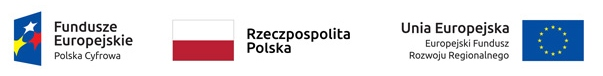</center>